JENSEN SHANNON

data

In [17]:
import pandas as pd
import numpy as np
from collections import Counter
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon

In [18]:
# Génération de données aléatoires
def generate_random_data(n, categories, weights):
    for i in range(n):
        category = random.choices(categories, weights=weights)[0]
        number   = random.randint(1, 200)
        yield {'Category': category, 'Number': number}

# Création des deux dataframes avec le nombre de donnée et de catégorie différente que je veux
def get_data(n_data, n_categories):
    categories          = ['fruit', 'légume', 'viande', 'poisson', 'intention','disk','player','population','oven','student','movie','agreement','procedure','actor', 'union', 'error', 'employee', 'security', 'region', 'user', 'cell', 'internet', 'wife', 'clothes']
    selected_categories = random.sample(categories, n_categories)
    
    weights_ref = [(random.randrange(1, 9)/10) for cat in selected_categories]
    weights_new = [(random.randrange(1, 9)/10) for cat in selected_categories]

    random_data_ref = generate_random_data(n_data, selected_categories, weights_ref)
    random_data_new = generate_random_data(n_data, selected_categories, weights_new)

    df_ref = pd.DataFrame(random_data_ref)
    df_new = pd.DataFrame(random_data_new)
    
    return [df_ref, df_new]

# Création de la liste des rangs de données et de colonnes
def number_data(data_range_min, data_range_max, range_col_min, range_col_max):
    data_list = []
    data      = data_range_min
    while data <= data_range_max:
        data_list.append(data)
        data *= 10
        
    col_list = []
    col_list.append(range_col_min)
    col_start = math.ceil((range_col_min+1)/10)*10
    for i in range(col_start, range_col_max+1, 10):
        col_list.append(i)
    
    return data_list, col_list

In [19]:
data_range_min = 500
data_range_max = 5000000
range_col_min  = 2
range_col_max  = 20

# Obtenir la liste des nombres de données et de catégories
data_list, col_list = number_data(data_range_min, data_range_max, range_col_min, range_col_max)

dfs = []
for n_data in data_list:
    for n_categories in col_list:
        df_ref, df_new = get_data(n_data, n_categories)
        df_name = str(n_data) + "_data_&_" + str(n_categories) + "_cat"
        dfs.append({'Stats': df_name, 'Data':(df_ref, df_new)})
print(f"Nombre de dataframes générés : {len(dfs)}")

Nombre de dataframes générés : 15


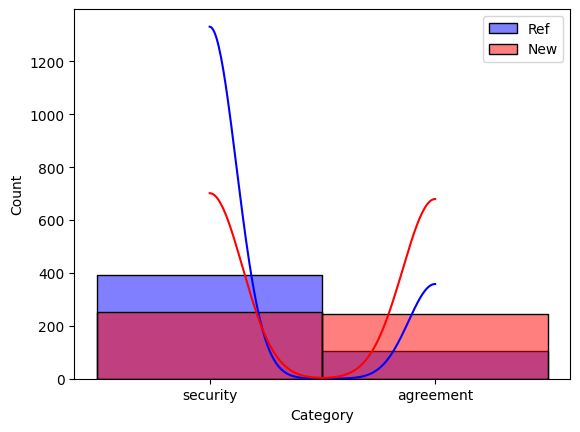

In [20]:
exemple_ref = dfs[0]['Data'][0]
exemple_new = dfs[0]['Data'][1]

# Tracer l'histogramme de chaque colonne des deux dataframes
sns.histplot(exemple_ref['Category'], color="blue", multiple="stack", kde=True, label='Ref')
sns.histplot(exemple_new['Category'], color="red", multiple="stack", kde=True, label='New')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()

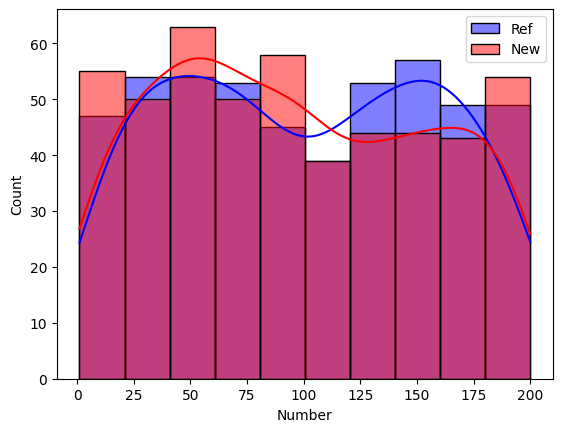

In [21]:
# Tracer l'histogramme de chaque colonne des deux dataframes
sns.histplot(exemple_ref['Number'], color="blue", multiple="stack", kde=True, label='Ref')
sns.histplot(exemple_new['Number'], color="red", multiple="stack", kde=True, label='New')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()

JS

In [22]:
def get_proba(column1, column2):
    distribution_1 = Counter(column1)
    distribution_2 = Counter(column2)

    ensemble_categories = set(list(distribution_1.keys()) + list(distribution_2.keys()))

    probabilites_1 = np.array([distribution_1.get(cat, 0) / float(sum(distribution_1.values())) for cat in ensemble_categories])
    probabilites_2 = np.array([distribution_2.get(cat, 0) / float(sum(distribution_2.values())) for cat in ensemble_categories])
    
    return [probabilites_1, probabilites_2]

def check_drift(js_prob):
    if js_prob > 0.1:
        drift_js_prob = True
    else:
        drift_js_prob = False
        
    return drift_js_prob

In [23]:
benchmark_prob = []
benchmark_num  = []

for df in dfs:    
    df_ref = df['Data'][0]
    df_new = df['Data'][1]
    
    for column in df_new.columns:
        if(df_new[column].dtype == np.float64 or df_new[column].dtype == np.int64):
            category    = "numeric"
            
            ref = df_ref[column]
            new = df_new[column]
            
            # Faire avec les chiffres
            js_nums     = jensenshannon(ref, new)
            
            # Faire avec le %
            probs       = get_proba(ref, new)
            drift_probs = jensenshannon(probs[0], probs[1])
            
            # Check le drift
            is_drift_num     = check_drift(js_nums)
            is_drift_prob    = check_drift(drift_probs)
    
            benchmark_num.append({'Df': df['Stats'],'column': column, 'type': category, 'js': round(js_nums, 3), 'drift_js': is_drift_num})
            benchmark_prob.append({'Df': df['Stats'],'column': column + "_prob", 'type': category, 'js': round(drift_probs, 3), 'drift_js': is_drift_prob})
        
        else:
            category    = "category"
            probs       = get_proba(df_ref[column], df_new[column])
            drift_probs = jensenshannon(probs[0], probs[1])
            is_drift    = check_drift(drift_probs)

            benchmark_num.append({'Df': df['Stats'], 'column': column + "_prob", 'type': category, 'js': round(drift_probs, 3), 'drift_js': is_drift})
            benchmark_prob.append({'Df': df['Stats'], 'column': column + "_prob", 'type': category, 'js': round(drift_probs, 3), 'drift_js': is_drift})

benchmark_df_pob = pd.DataFrame(benchmark_prob)
benchmark_df_num = pd.DataFrame(benchmark_num)

In [24]:
benchmark_df_pob

,Df,column,type,js,drift_js
0,500_data_&_2_cat,Category_prob,category,0.209,True
1,500_data_&_2_cat,Number_prob,numeric,0.344,True
2,500_data_&_10_cat,Category_prob,category,0.364,True
3,500_data_&_10_cat,Number_prob,numeric,0.346,True
4,500_data_&_20_cat,Category_prob,category,0.290,True
5,500_data_&_20_cat,Number_prob,numeric,0.335,True
6,5000_data_&_2_cat,Category_prob,category,0.108,True
7,5000_data_&_2_cat,Number_prob,numeric,0.096,False
8,5000_data_&_10_cat,Category_prob,category,0.301,True
9,5000_data_&_10_cat,Number_prob,numeric,0.098,False


In [25]:
benchmark_df_num

,Df,column,type,js,drift_js
0,500_data_&_2_cat,Category_prob,category,0.209,True
1,500_data_&_2_cat,Number,numeric,0.316,True
2,500_data_&_10_cat,Category_prob,category,0.364,True
3,500_data_&_10_cat,Number,numeric,0.308,True
4,500_data_&_20_cat,Category_prob,category,0.290,True
5,500_data_&_20_cat,Number,numeric,0.335,True
6,5000_data_&_2_cat,Category_prob,category,0.108,True
7,5000_data_&_2_cat,Number,numeric,0.313,True
8,5000_data_&_10_cat,Category_prob,category,0.301,True
9,5000_data_&_10_cat,Number,numeric,0.318,True
